In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  MaxPooling2D,GlobalMaxPooling2D,Reshape,Concatenate,BatchNormalization,UpSampling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Add,Multiply, Conv2D,  Activation, GlobalAveragePooling2D,Lambda

2025-03-31 19:29:32.605839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743429572.634106   11672 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743429572.642369   11672 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743429572.664138   11672 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743429572.664167   11672 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743429572.664170   11672 computation_placer.cc:177] computation placer alr

In [2]:
warnings.filterwarnings("ignore")

In [3]:
base_dir = '/home/rahul/Deep learning/TransferLearning/Dataset/PlantDataset'
subdirs = ['train', 'test', 'valid']

In [4]:
data = []
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                if '_test' in class_name:
                        data.append({'filepath': img_path, 'label': class_name.replace('_test','')})
                elif  '_valid' in class_name:
                        data.append({'filepath': img_path, 'label': class_name.replace('_valid','')})
                else:
                       data.append({'filepath': img_path, 'label': class_name})


In [5]:
df = pd.DataFrame(data)

In [6]:
df.head()

,filepath,label
0,/home/rahul/Deep learning/TransferLearning/Dat...,Blast
1,/home/rahul/Deep learning/TransferLearning/Dat...,Blast
2,/home/rahul/Deep learning/TransferLearning/Dat...,Blast
3,/home/rahul/Deep learning/TransferLearning/Dat...,Blast
4,/home/rahul/Deep learning/TransferLearning/Dat...,Blast


In [7]:
def changeLabel(x):
    if x == 'mildew':
        return 'Mildew'
    elif x == 'leaf_blight':
        return 'Leaf Blight'
    elif x == 'yellow_rust':
        return 'Yellow Rust'
    elif x == 'stem_fly':
        return 'Stem fly'
    elif x == 'fusarium_head_blight':
        return 'Fusarium Head Blight'
    elif x == 'brown_rust':
        return 'Brown Rust'
    elif x == 'smut':
        return 'Smut'
    elif x == 'healthy':
        return 'Healthy'
    elif x == 'black_rust':
        return 'Black Rust'
    elif x == 'mite':
        return 'Mite'
    elif x == 'blast_valid':
        return 'Blast'
    elif x == 'aphid':
        return 'Aphid'
    elif x == 'tan_spot':
        return 'Tan spot'
    elif x == 'common_root_rot':
        return 'Common Root Rot'
    elif x == 'septoria':
        return 'Septoria'
    elif x == 'blast':
        return 'Blast'
    else:
        return x


In [8]:
df['label'] = df['label'].apply(changeLabel)

In [9]:
classes = ['Aphid',
 'Black Rust',
 'Blast',
 'Brown Rust',
 'Common Root Rot',
 'Fusarium Head Blight',
 'Healthy',
 'Leaf Blight',
 'Mildew',
 'Mite',
 'Septoria',
 'Smut',
 'Stem fly',
 'Tan spot',
 'Yellow Rust']


In [10]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [11]:
def apply_clahe(image):
    image = np.array(image, dtype=np.uint8)
    if image.ndim == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        lab = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced_img = clahe.apply(image)
    return enhanced_img.astype('float32')

In [12]:
test_df['label'].value_counts()

label
Smut                    207
Yellow Rust             206
Brown Rust              202
Septoria                182
Mildew                  173
Healthy                 161
Aphid                   146
Leaf Blight             137
Mite                    131
Tan spot                126
Blast                   107
Fusarium Head Blight    102
Common Root Rot         102
Black Rust               97
Stem fly                 45
Name: count, dtype: int64

In [13]:
test_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    rescale=1./255
)

In [14]:
test_data = test_datagen.flow_from_dataframe(test_df,
                                            x_col='filepath',
                                            y_col='label',        
                                          target_size=(224,224),
                                          class_mode='categorical',
                                             shuffle=False,
                                          batch_size=32)

Found 2124 validated image filenames belonging to 15 classes.


In [15]:
num_classes= 15

In [16]:
def channel_attention(input_feature, reduction_ratio=8):
    channels = input_feature.shape[-1]
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    shared_dense = Dense(channels // reduction_ratio, activation='relu',use_bias=False)
    shared_dense_out = Dense(channels, activation='sigmoid',use_bias=False)

    avg_out = shared_dense_out(shared_dense(avg_pool))
    max_out = shared_dense_out(shared_dense(max_pool))

    scale = avg_out + max_out
    scale = Activation('sigmoid')(scale)

    return Multiply()([input_feature, scale])

def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.expand_dims(tf.reduce_mean(x, axis=-1), axis=-1))(input_feature)
    max_pool = Lambda(lambda x: tf.expand_dims(tf.reduce_max(x, axis=-1), axis=-1))(input_feature)

    concat = Concatenate()([avg_pool, max_pool])
    attention_map = Conv2D(filters=1, kernel_size=7, padding="same", activation='sigmoid')(concat)

    return Multiply()([input_feature, attention_map])

def cbam_block(input_feature):
    x = channel_attention(input_feature)
    x = spatial_attention(x)
    return x



In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
# Insert CBAM in a few layers
x = base_model.output
x = cbam_block(x)  # Add CBAM to the last feature map
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Adjust output classes as needed

# Final Model
cbam_model = Model(inputs=base_model.input, outputs=x)

# Compile
cbam_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1743429576.461946   11672 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 748 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [18]:
cbam_model.load_weights('cbam.h5')

In [19]:
def BAM(x):
    ca = channel_attention(x)
    sa = spatial_attention(ca)
    return Add()([x, sa])

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output
x = BAM(x)
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)
bam_model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [21]:
bam_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
bam_model.load_weights('bam.h5')

In [23]:
def build_mobilenetv2_cbam_ssd(input_shape=(224, 224, 3), num_classes=15):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = cbam_block(x)  # Apply CBAM after feature extraction
    x = Conv2D(512, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(num_classes + 4, kernel_size=1, padding='same')(x)  # Class + 4 bbox coords
    x = GlobalAveragePooling2D()(x)
    output = Dense(15,activation='sigmoid')(x)  # Adjust activation based on need

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create model
ssd_model = build_mobilenetv2_cbam_ssd()

In [24]:
ssd_model.load_weights('ssd.h5')

In [25]:
def autoencoder_block(input_tensor):
    """Autoencoder to refine feature maps."""
    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)  # Upsampling to refine features
    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    
    return x

In [26]:
def classification_head(x, num_classes=15):
    """Classification head with fully connected layers."""
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Softmax for classification
    
    return x

In [27]:
def build_model(input_shape=(224, 224, 3), num_classes=15):
    """Builds MobileNet + CBAM + Autoencoder Model for Classification"""
    
    # Load MobileNetV2 as Backbone
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable=False
    x = base_model.output
    
    # Add CBAM Attention
    x = cbam_block(x)
    
    # Autoencoder Feature Refinement
    x = autoencoder_block(x)
    
    # Classification Head
    output = classification_head(x, num_classes)
    
    # Define Model
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [28]:
cbam_ae_model = build_model()
cbam_ae_model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cbam_ae_model.load_weights('combined.h5')

In [29]:
cbam_predictions = cbam_model.predict(test_data)

I0000 00:00:1743429588.942231   11714 service.cc:152] XLA service 0x7de2380050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743429588.942255   11714 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-31 19:29:48.996380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743429589.698946   11714 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/67 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step  

I0000 00:00:1743429595.953387   11714 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 697ms/step


In [30]:
bam_predictions = bam_model.predict(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 711ms/step


In [31]:
ssd_predictions = ssd_model.predict(test_data)

2025-03-31 19:31:43.312712: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[32,512,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0} %bitcast.6761, f32[512,1280,3,3]{3,2,1,0} %bitcast.6768, f32[512]{0} %bitcast.6770), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/conv2d_3_1/convolution" source_file="/home/rahul/.local/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-31 19:31:43.771978: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran

66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step

2025-03-31 19:32:27.254210: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[12,512,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,1280,7,7]{3,2,1,0} %bitcast.6761, f32[512,1280,3,3]{3,2,1,0} %bitcast.6768, f32[512]{0} %bitcast.6770), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/conv2d_3_1/convolution" source_file="/home/rahul/.local/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-31 19:32:27.407857: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran

67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 657ms/step


In [32]:
cbam_ae_predictions = cbam_ae_model.predict(test_data)

2025-03-31 19:32:35.214112: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[32,256,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0} %bitcast.6951, f32[256,1280,3,3]{3,2,1,0} %bitcast.6958, f32[256]{0} %bitcast.6960), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_6_1/convolution" source_file="/home/rahul/.local/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-31 19:32:35.491991: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran

66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step

2025-03-31 19:33:21.618812: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[12,256,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,1280,7,7]{3,2,1,0} %bitcast.6951, f32[256,1280,3,3]{3,2,1,0} %bitcast.6958, f32[256]{0} %bitcast.6960), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_6_1/convolution" source_file="/home/rahul/.local/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-31 19:33:21.723382: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran

67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 698ms/step


In [33]:
cbam_cm = confusion_matrix(y_pred=np.argmax(cbam_predictions,axis=1),y_true=test_data.classes)
print(cbam_cm)

[[120   2   1   0   0   0   1   2   1  13   0   1   2   3   0]
 [  0  74   4   2   0   1   3   2   2   0   1   1   0   6   1]
 [  0   0 101   0   1   2   1   1   0   0   0   0   0   1   0]
 [  2  25   0 157   0   0   7   2   1   1   1   0   0   4   2]
 [  1   0  13   0  77   1   1   1   0   6   0   0   0   2   0]
 [  0   0   6   0   0  96   0   0   0   0   0   0   0   0   0]
 [  0   2   3   4   0   0 143   1   0   0   0   0   0   1   7]
 [  4   6   3   2   1   2   0  89   0   2   4   2   0  22   0]
 [  4   6   0   5   1   0   9   5 135   0   0   1   1   4   2]
 [  5   1   2   2   2   0   2   3   0 108   0   0   0   6   0]
 [  0   1   0   8   0   0   7   9   2   0 153   0   0   1   1]
 [  0   2  40   0   4   4   1   0   3   2   0 145   2   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  45   0   0]
 [  3   3   8   4   4   0   1  12   2   4   0   1   0  84   0]
 [  0   5   0   1   0   0   2   0   1   0   5   0   0   2 190]]


In [34]:
bam_cm = confusion_matrix(y_pred=np.argmax(bam_predictions,axis=1),y_true=test_data.classes)
print(bam_cm)

[[104   7   0   0   0   2   1   3   1   9   1   6   9   3   0]
 [  0  77   1  14   0   0   2   0   1   0   1   1   0   0   0]
 [  0  10  79   0   2   2   1   1   1   0   0   8   1   2   0]
 [  1  20   0 162   1   0   9   2   1   0   3   0   0   1   2]
 [  1   8   5   2  78   1   2   2   0   2   0   0   0   1   0]
 [  0   1   0   0   0  92   0   1   0   0   0   8   0   0   0]
 [  0   7   0   6   0   0 136   2   3   0   2   1   0   0   4]
 [  3  20   0   9   2   0   4  81   3   2   2   4   1   6   0]
 [  1   6   0   6   0   0  11   5 128   2   8   2   0   2   2]
 [  5   3   1   4   6   1   2   1   0  97   0   6   2   3   0]
 [  0   8   0  13   0   0   8  12   2   0 136   0   0   2   1]
 [  0  12   4   2   3   3   3   3   3   0   0 170   3   1   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0  44   0   0]
 [  1  26   4  13   5   0   4  14   4   4   1   6   0  44   0]
 [  0   6   0  10   0   0   4   0   3   0   2   0   0   1 180]]


In [35]:
ssd_cm = confusion_matrix(y_pred=np.argmax(ssd_predictions,axis=1),y_true=test_data.classes)
print(ssd_cm)

[[131   1   1   0   0   1   1   3   1   1   0   4   2   0   0]
 [  0  77   1   5   1   0   4   3   3   0   0   2   0   1   0]
 [  0   1  96   0   2   2   1   1   0   0   0   3   0   1   0]
 [  2  20   0 155   0   0  13   5   0   1   3   0   0   3   0]
 [  3   1   6   0  81   1   2   2   0   2   0   0   1   3   0]
 [  0   0   6   0   0  87   0   1   0   0   0   8   0   0   0]
 [  0   3   1   1   0   0 156   0   0   0   0   0   0   0   0]
 [  5   3   0   2   1   0   3 104   1   2   1   8   1   6   0]
 [  4   4   0   1   0   0  21   9 127   0   2   4   0   1   0]
 [ 10   1   0   0   5   1   3   3   0 101   0   3   2   2   0]
 [  0   2   0   6   0   0  10  15   2   0 145   0   0   1   1]
 [  2   1   7   0   1   3   0   3   0   0   0 187   2   1   0]
 [  2   0   0   0   0   0   0   0   0   0   0   1  42   0   0]
 [  5   2   5   3   5   0   3  11   2   1   0   7   0  82   0]
 [  2   5   0   5   0   0  20   1   3   0   6   0   0   3 161]]


In [36]:
cbam_ae_cm  = confusion_matrix(y_pred=np.argmax(cbam_ae_predictions,axis=1),y_true=test_data.classes)
print(cbam_ae_cm)

[[ 81   0   3   4   2   4   4   5   1  21   1   6   5   9   0]
 [  0  76   0   5   0   0   1   1   1   0  10   0   0   3   0]
 [  0   6  96   0   1   2   0   1   0   0   0   1   0   0   0]
 [  1  43   0 134   0   0  10   2   0   1   8   0   0   2   1]
 [  0   2  15   0  68   2   5   2   0   7   1   0   0   0   0]
 [  0   1   2   0   0  97   0   0   0   0   1   1   0   0   0]
 [  0   6   2   7   0   0 134   0   2   0   5   0   0   0   5]
 [  0  12   5   6   2   1   2  61   8   0  24   2   0  14   0]
 [  0   3   0   6   1   2   5   6 132   0  17   1   0   0   0]
 [  4   1   3   3  11   1   2   5   3  83   1   4   2   8   0]
 [  0   3   0   2   0   0   1   0   0   0 176   0   0   0   0]
 [  0   5  37   5   1   6   1   3   1   1   5 142   0   0   0]
 [  1   0   0   2   0   1   0   0   0   0   0   1  40   0   0]
 [  4  20   8   5   5   0   6  19   5   5   8   2   0  39   0]
 [  0   3   0   3   0   0   1   0   2   0  22   0   0   0 175]]


Text(0.5, 1.0, 'CBAM Model Confusion Matrix')

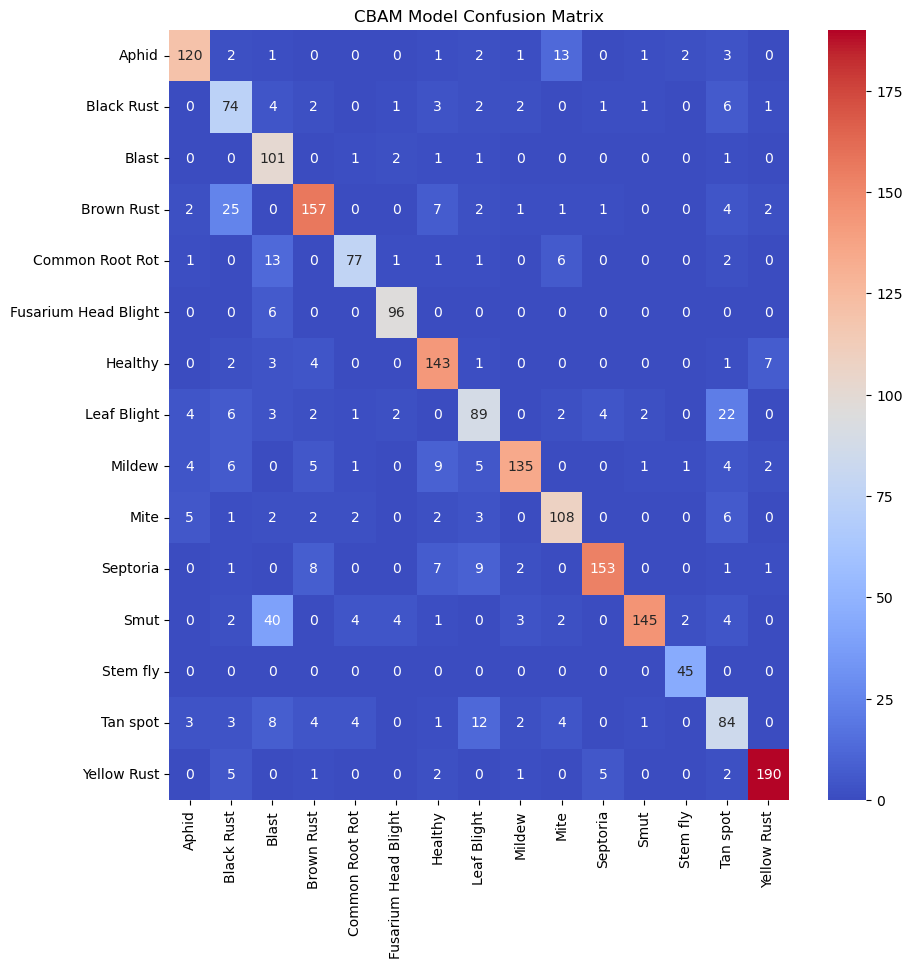

In [37]:
plt.figure(figsize=(10, 10))
sns.heatmap(cbam_cm,xticklabels=classes,yticklabels=classes,annot=True,cmap="coolwarm",fmt="")
plt.title("CBAM Model Confusion Matrix")

Text(0.5, 1.0, 'BAM Model Confusion Matrix')

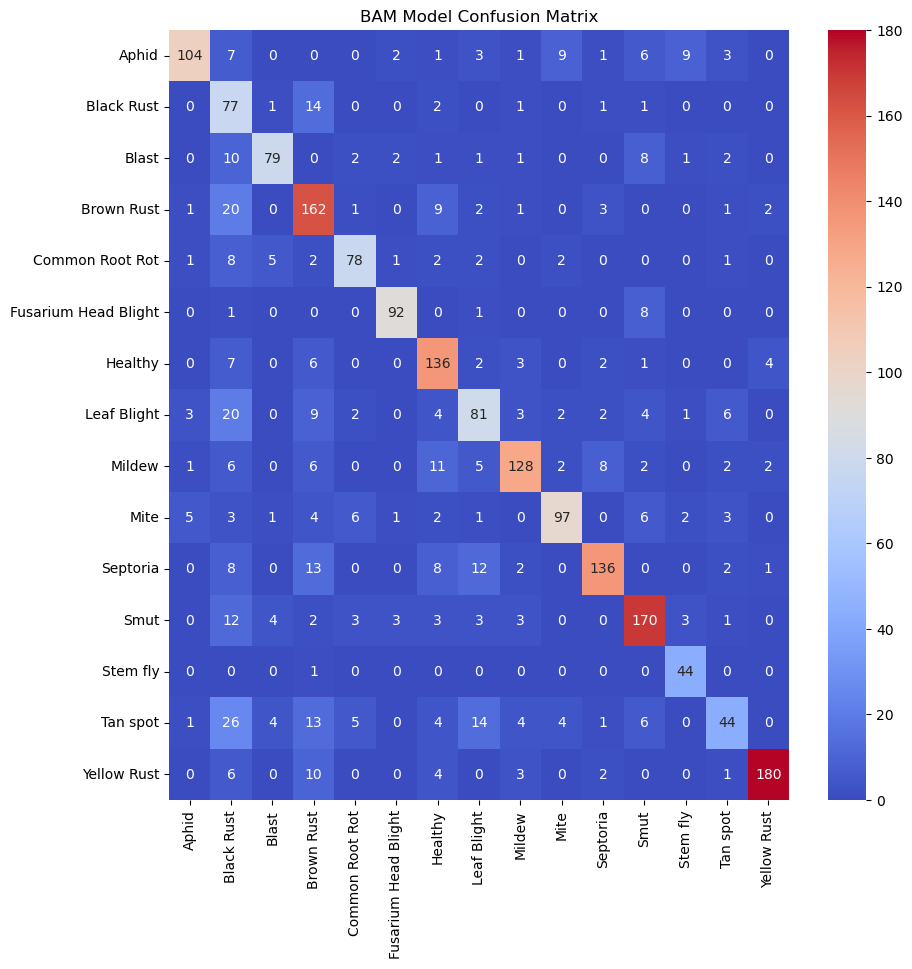

In [38]:
plt.figure(figsize=(10, 10))
sns.heatmap(bam_cm,xticklabels=classes,yticklabels=classes,annot=True,cmap="coolwarm",fmt="")
plt.title("BAM Model Confusion Matrix")

Text(0.5, 1.0, 'SSD CBAMobile Detector Model Confusion Matrix')

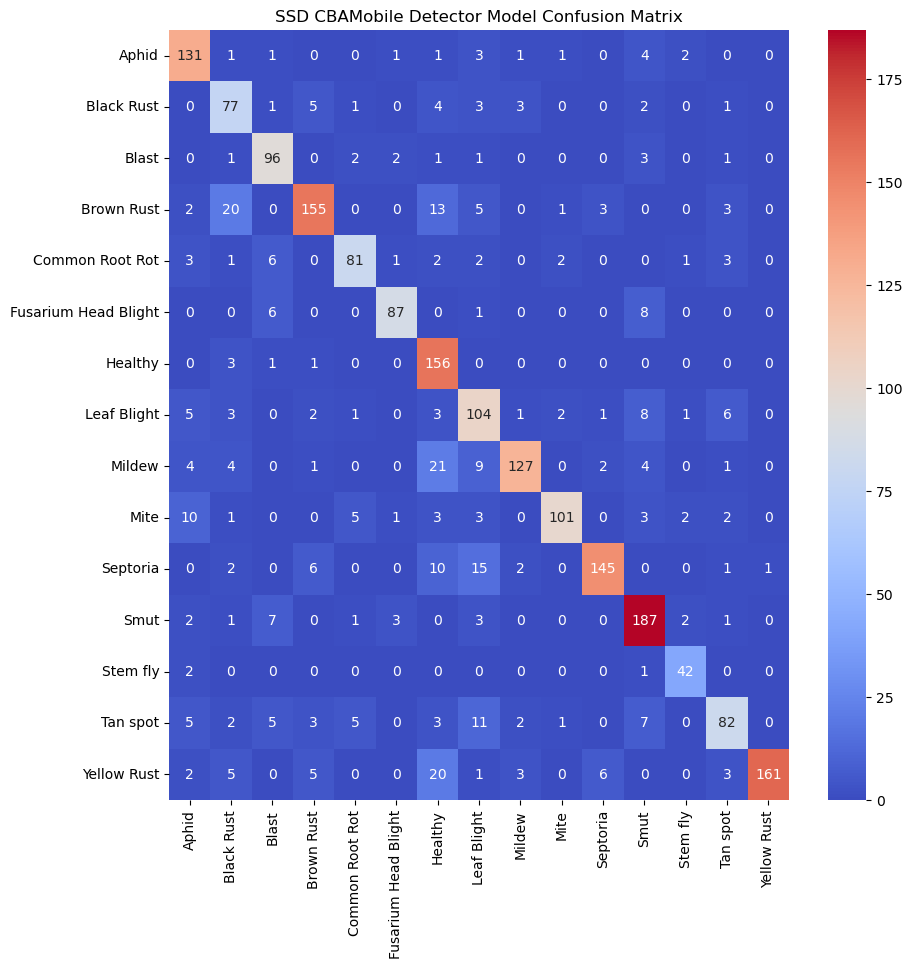

In [39]:
plt.figure(figsize=(10, 10))
sns.heatmap(ssd_cm,xticklabels=classes,yticklabels=classes,annot=True,cmap="coolwarm",fmt="")
plt.title("SSD CBAMobile Detector Model Confusion Matrix")

Text(0.5, 1.0, 'CBAM AutoEncoder Classification Head Model Confusion Matrix')

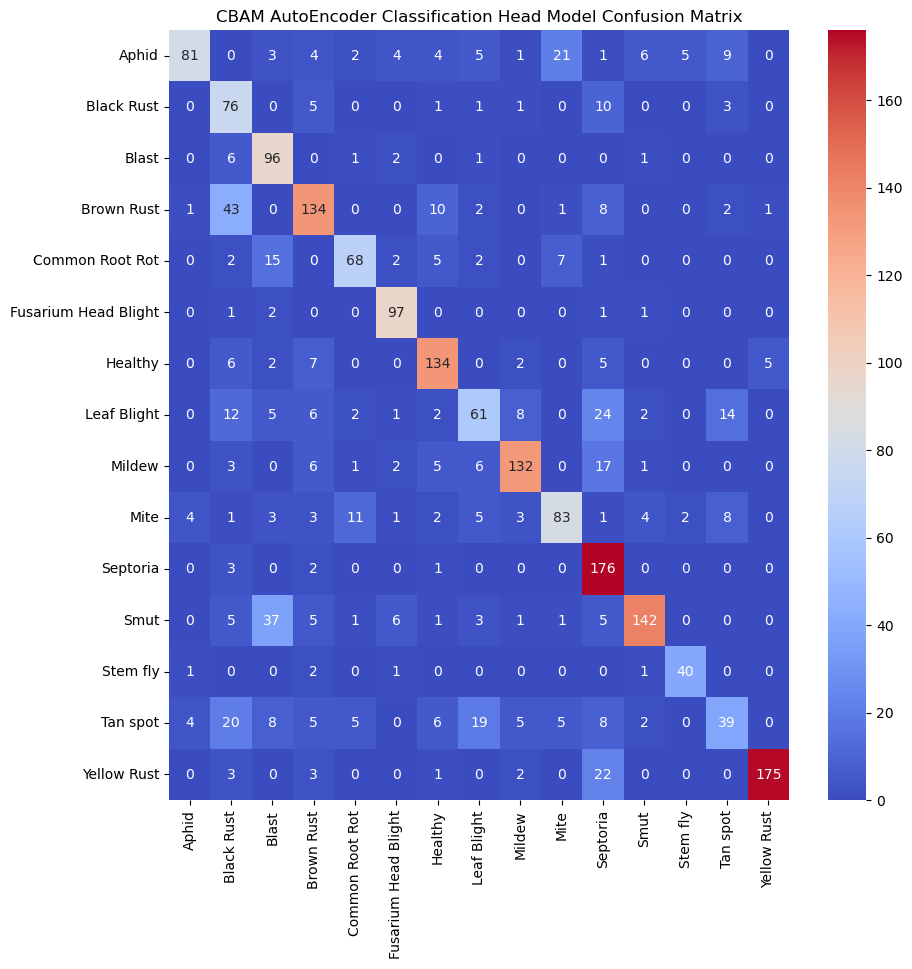

In [40]:
plt.figure(figsize=(10, 10))
sns.heatmap(cbam_ae_cm,xticklabels=classes,yticklabels=classes,annot=True,cmap="coolwarm",fmt="")
plt.title("CBAM AutoEncoder Classification Head Model Confusion Matrix")

In [41]:
cbam_classificationReport = classification_report(y_pred=np.argmax(cbam_predictions,axis=1),y_true=test_data.classes,target_names=classes)
print(cbam_classificationReport)

                      precision    recall  f1-score   support

               Aphid       0.86      0.82      0.84       146
          Black Rust       0.58      0.76      0.66        97
               Blast       0.56      0.94      0.70       107
          Brown Rust       0.85      0.78      0.81       202
     Common Root Rot       0.86      0.75      0.80       102
Fusarium Head Blight       0.91      0.94      0.92       102
             Healthy       0.80      0.89      0.84       161
         Leaf Blight       0.70      0.65      0.67       137
              Mildew       0.92      0.78      0.84       173
                Mite       0.79      0.82      0.81       131
            Septoria       0.93      0.84      0.88       182
                Smut       0.96      0.70      0.81       207
            Stem fly       0.90      1.00      0.95        45
            Tan spot       0.60      0.67      0.63       126
         Yellow Rust       0.94      0.92      0.93       206

      

In [42]:
bam_classificationReport = classification_report(y_pred=np.argmax(bam_predictions,axis=1),y_true=test_data.classes,target_names=classes)
print(bam_classificationReport)

                      precision    recall  f1-score   support

               Aphid       0.90      0.71      0.79       146
          Black Rust       0.36      0.79      0.50        97
               Blast       0.84      0.74      0.79       107
          Brown Rust       0.67      0.80      0.73       202
     Common Root Rot       0.80      0.76      0.78       102
Fusarium Head Blight       0.91      0.90      0.91       102
             Healthy       0.73      0.84      0.78       161
         Leaf Blight       0.64      0.59      0.61       137
              Mildew       0.85      0.74      0.79       173
                Mite       0.84      0.74      0.79       131
            Septoria       0.87      0.75      0.80       182
                Smut       0.80      0.82      0.81       207
            Stem fly       0.73      0.98      0.84        45
            Tan spot       0.67      0.35      0.46       126
         Yellow Rust       0.95      0.87      0.91       206

      

In [43]:
ssd_classificationReport = classification_report(y_pred=np.argmax(ssd_predictions,axis=1),y_true=test_data.classes,target_names=classes)
print(ssd_classificationReport)

                      precision    recall  f1-score   support

               Aphid       0.79      0.90      0.84       146
          Black Rust       0.64      0.79      0.71        97
               Blast       0.78      0.90      0.83       107
          Brown Rust       0.87      0.77      0.82       202
     Common Root Rot       0.84      0.79      0.82       102
Fusarium Head Blight       0.92      0.85      0.88       102
             Healthy       0.66      0.97      0.78       161
         Leaf Blight       0.65      0.76      0.70       137
              Mildew       0.91      0.73      0.81       173
                Mite       0.94      0.77      0.85       131
            Septoria       0.92      0.80      0.86       182
                Smut       0.82      0.90      0.86       207
            Stem fly       0.84      0.93      0.88        45
            Tan spot       0.79      0.65      0.71       126
         Yellow Rust       0.99      0.78      0.88       206

      

In [44]:
cbam_ae_classificationReport = classification_report(y_pred=np.argmax(cbam_ae_predictions,axis=1),y_true=test_data.classes,target_names=classes)
print(cbam_ae_classificationReport)

                      precision    recall  f1-score   support

               Aphid       0.89      0.55      0.68       146
          Black Rust       0.42      0.78      0.55        97
               Blast       0.56      0.90      0.69       107
          Brown Rust       0.74      0.66      0.70       202
     Common Root Rot       0.75      0.67      0.70       102
Fusarium Head Blight       0.84      0.95      0.89       102
             Healthy       0.78      0.83      0.80       161
         Leaf Blight       0.58      0.45      0.50       137
              Mildew       0.85      0.76      0.80       173
                Mite       0.70      0.63      0.67       131
            Septoria       0.63      0.97      0.76       182
                Smut       0.89      0.69      0.77       207
            Stem fly       0.85      0.89      0.87        45
            Tan spot       0.52      0.31      0.39       126
         Yellow Rust       0.97      0.85      0.90       206

      

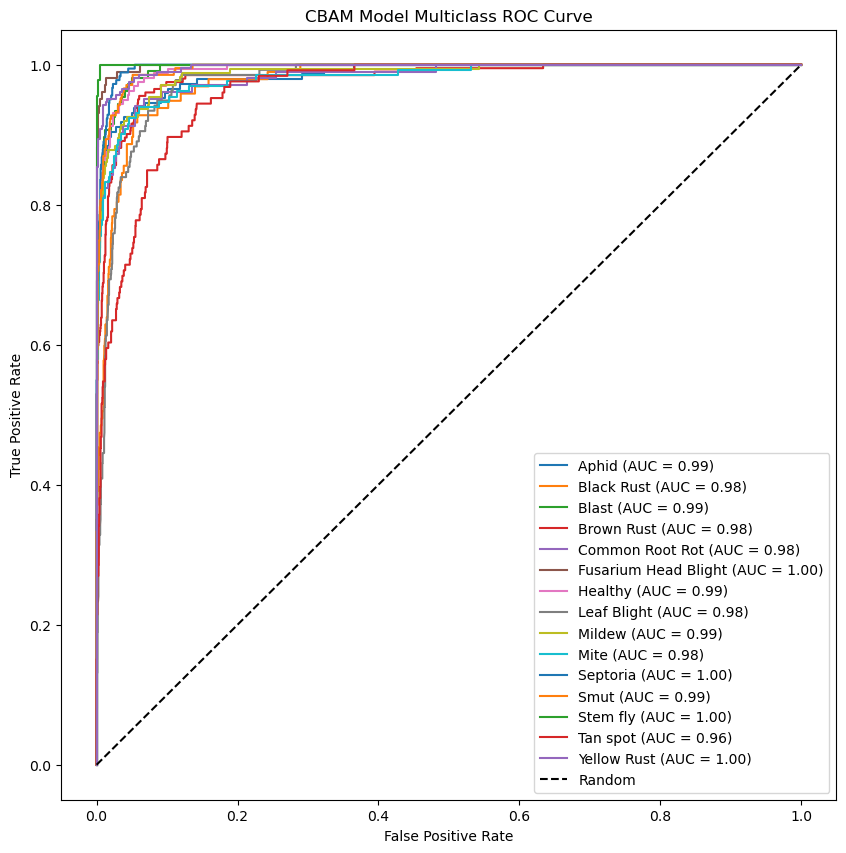

In [45]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CBAM Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

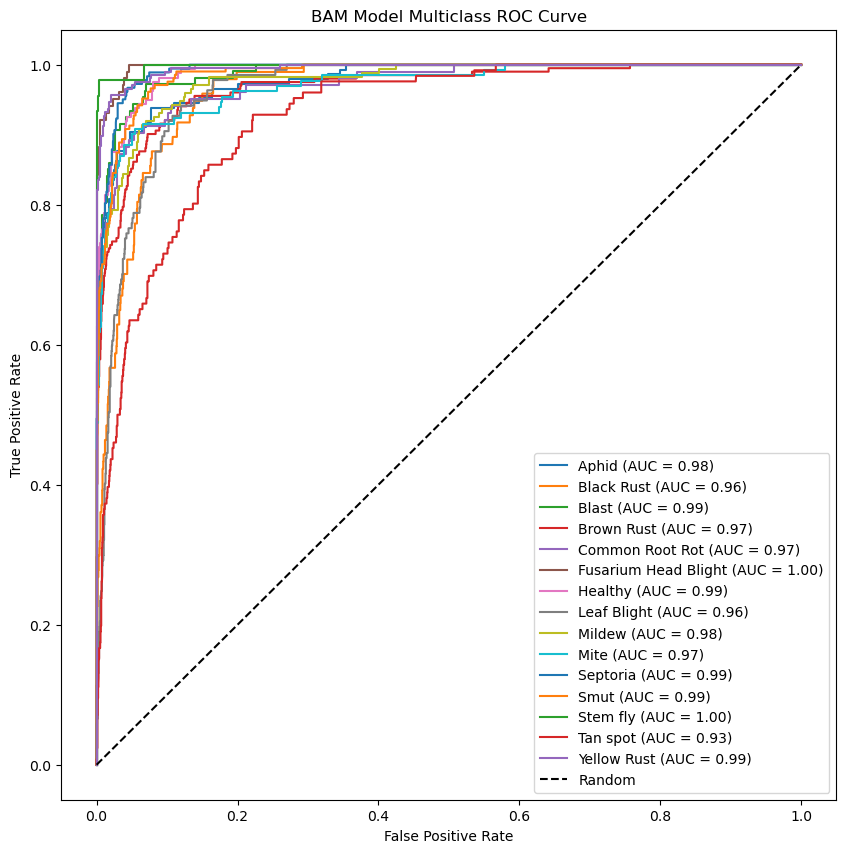

In [46]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = bam_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BAM Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

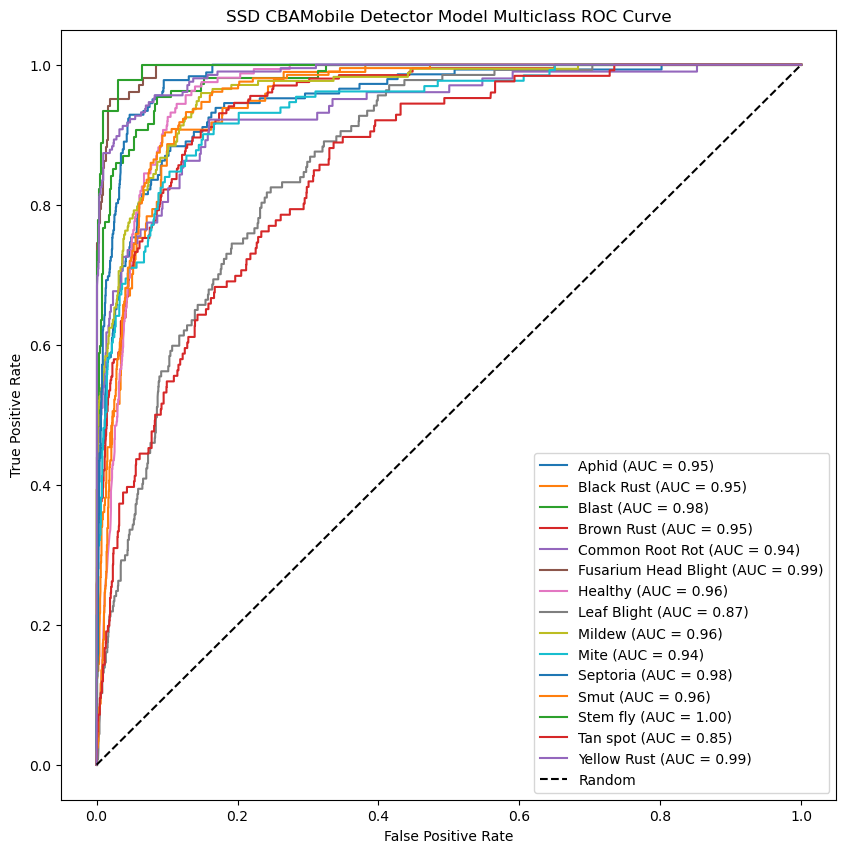

In [47]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = ssd_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SSD CBAMobile Detector Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

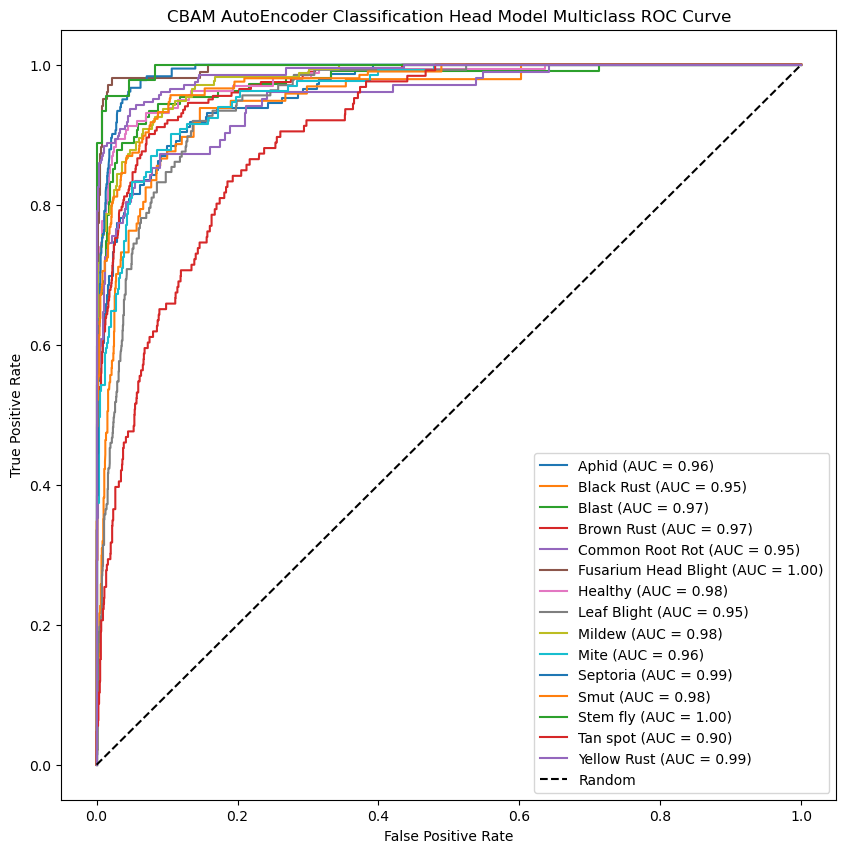

In [48]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_ae_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CBAM AutoEncoder Classification Head Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

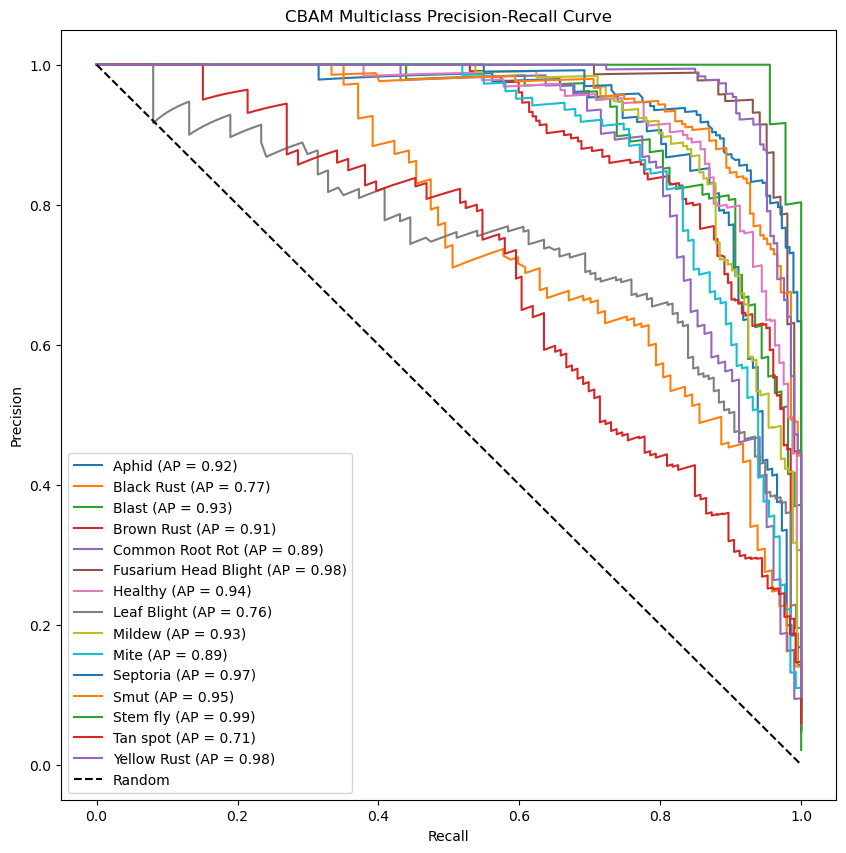

In [49]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CBAM Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


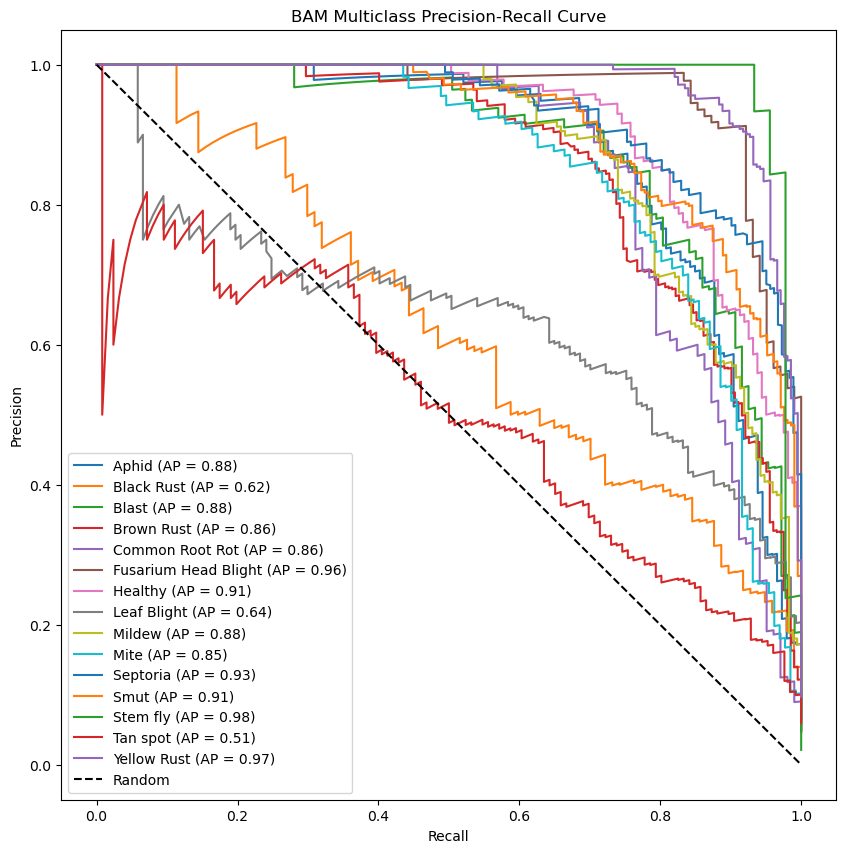

In [50]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = bam_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('BAM Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

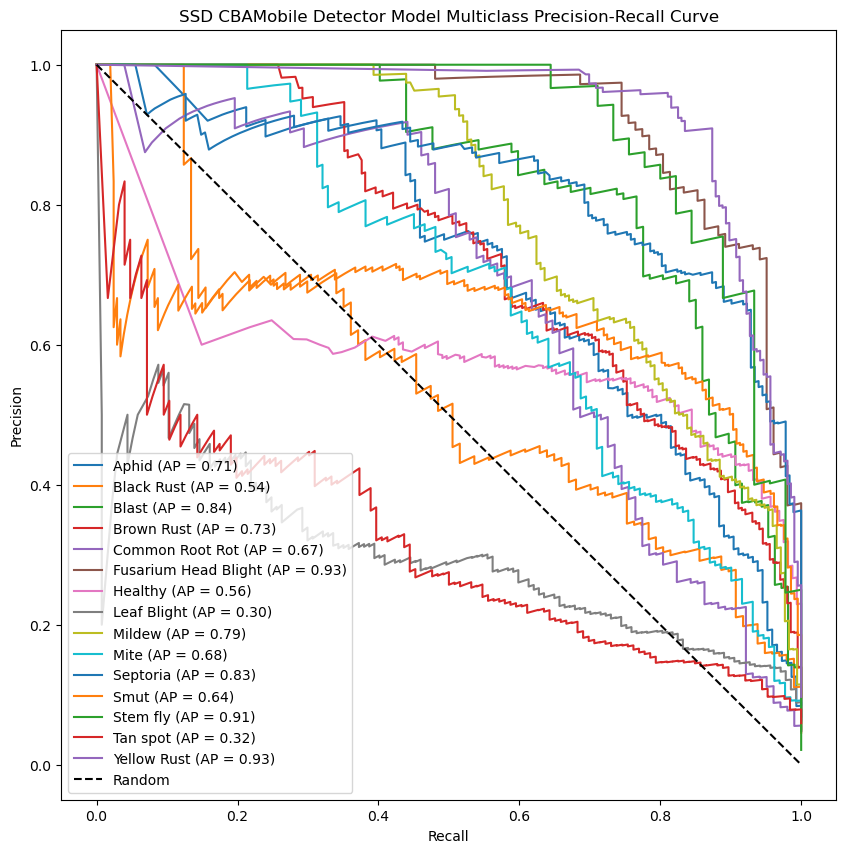

In [51]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = ssd_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SSD CBAMobile Detector Model Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

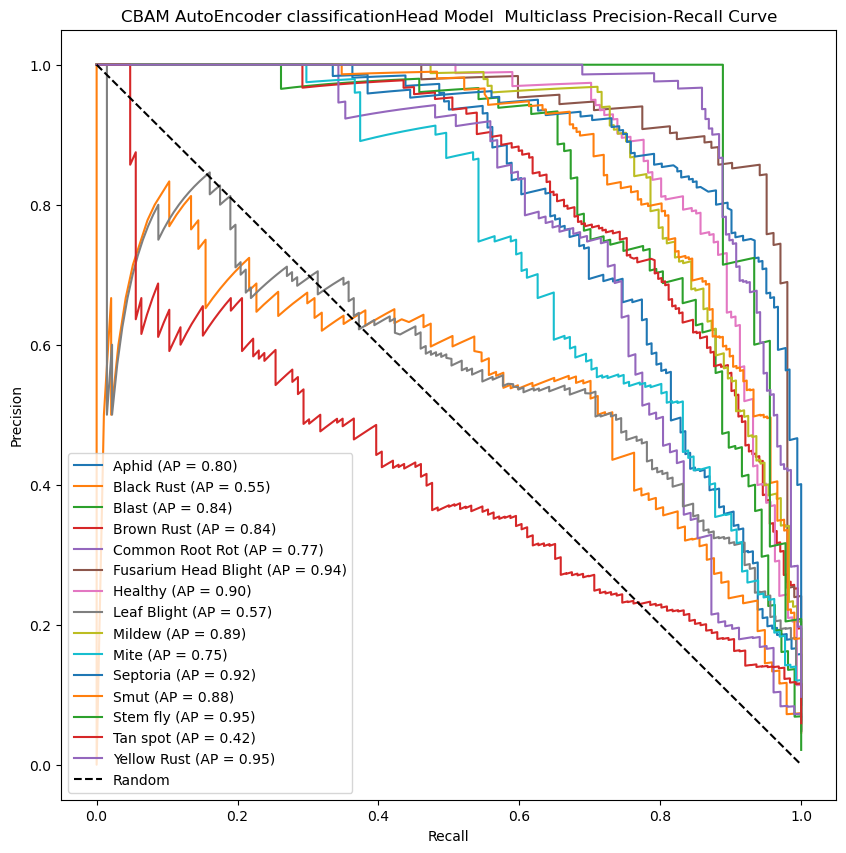

In [52]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_ae_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CBAM AutoEncoder classificationHead Model  Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [53]:
cbam_df = pd.read_csv('/home/rahul/Deep learning/project/cbam_data.csv')
cbam_ae_df = pd.read_csv('/home/rahul/Deep learning/project/cbam_ae_results.csv')
bam_df = pd.read_csv('/home/rahul/Deep learning/project/bam_data.csv')
ssd_df = pd.read_csv('/home/rahul/Deep learning/project/ssd_data.csv')

In [54]:
cbam_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.567276,1.376405,0.638248,1.069788
1,0.676491,0.976579,0.682525,0.976844
2,0.714747,0.853794,0.690532,0.920174
3,0.742102,0.765152,0.706076,0.879570
4,0.761986,0.699882,0.708902,0.877083


In [55]:
cbam_ae_df.head()

,Epoch,Accuracy,Validation Accuracy,Loss,Validation Loss
0,1,0.3503,0.5775,2.0578,1.3571
1,2,0.5896,0.6227,1.3212,1.1669
2,3,0.6252,0.6547,1.1939,1.1139
3,4,0.6607,0.6811,1.0823,0.9907
4,5,0.6822,0.6571,0.9979,1.0821


In [56]:
bam_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.517917,1.583064,0.604805,1.264642
1,0.643888,1.118715,0.654734,1.073314
2,0.678409,0.986428,0.670278,1.035498
3,0.693954,0.928569,0.682054,0.990127
4,0.717271,0.863912,0.684409,0.996781


In [57]:
ssd_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.544464,1.519064,0.617522,1.122801
1,0.667306,1.010606,0.644371,1.089217
2,0.703038,0.871441,0.688177,0.935427
3,0.738670,0.761044,0.698540,0.908085
4,0.754921,0.718182,0.708431,0.887725


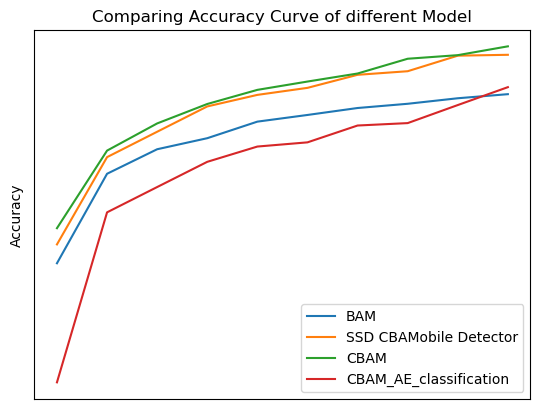

In [58]:
plt.plot(np.arange(1,11),bam_df['accuracy'],label='BAM')
plt.plot(np.arange(1,11),ssd_df['accuracy'],label='SSD CBAMobile Detector')
plt.plot(np.arange(1,11),cbam_df['accuracy'],label='CBAM')
plt.plot(np.arange(1,11),cbam_ae_df['Accuracy'],label='CBAM_AE_classification')
plt.title('Comparing Accuracy Curve of different Model')
plt.legend()
plt.xticks([])  
plt.yticks([])  
plt.ylabel('Accuracy')
plt.show()

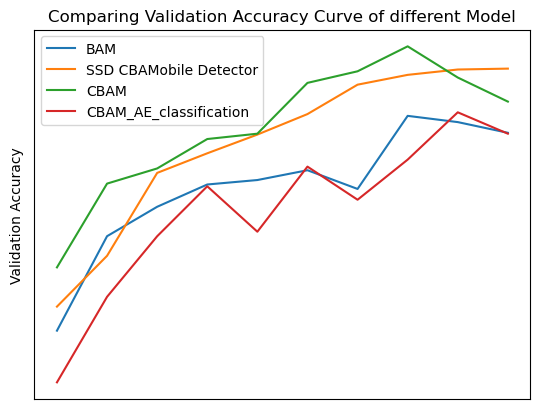

In [59]:
plt.plot(np.arange(1,11),bam_df['val_accuracy'],label='BAM')
plt.plot(np.arange(1,11),ssd_df['val_accuracy'],label='SSD CBAMobile Detector')
plt.plot(np.arange(1,11),cbam_df['val_accuracy'],label='CBAM')
plt.plot(np.arange(1,11),cbam_ae_df['Validation Accuracy'],label='CBAM_AE_classification')
plt.title('Comparing Validation Accuracy Curve of different Model')
plt.legend()
plt.xticks([])  
plt.yticks([])  
plt.ylabel('Validation Accuracy')
plt.show()

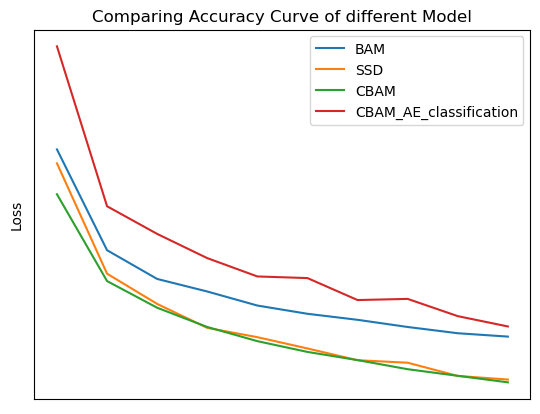

In [60]:
plt.plot(np.arange(1,11),bam_df['loss'],label='BAM')
plt.plot(np.arange(1,11),ssd_df['loss'],label='SSD')
plt.plot(np.arange(1,11),cbam_df['loss'],label='CBAM')
plt.plot(np.arange(1,11),cbam_ae_df['Loss'],label='CBAM_AE_classification')
plt.title('Comparing Accuracy Curve of different Model')
plt.legend()
plt.xticks([])  
plt.yticks([])  
plt.ylabel('Loss')
plt.show()

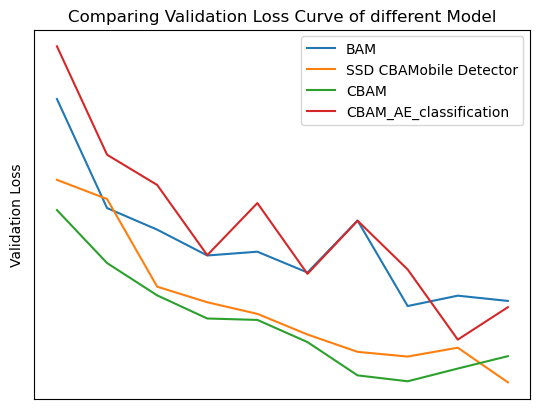

In [61]:
plt.plot(np.arange(1,11),bam_df['val_loss'],label='BAM')
plt.plot(np.arange(1,11),ssd_df['val_loss'],label='SSD CBAMobile Detector')
plt.plot(np.arange(1,11),cbam_df['val_loss'],label='CBAM')
plt.plot(np.arange(1,11),cbam_ae_df['Validation Loss'],label='CBAM_AE_classification')
plt.title('Comparing Validation Loss Curve of different Model')
plt.legend()
plt.xticks([])  
plt.yticks([])  
plt.ylabel('Validation Loss')
plt.show()

In [62]:
selected_classes = [
    "Aphid",
    "Blast",
    "Healthy",
    "Smut",
    "Stem fly"
]

In [63]:
selected_indices = [0, 2, 6, 11, 12]

In [64]:
filtered_cbam_cm = cbam_cm[np.ix_(selected_indices, selected_indices)]

In [65]:
filtered_bam_cm = bam_cm[np.ix_(selected_indices, selected_indices)]

In [66]:
filtered_ssd_cm = ssd_cm[np.ix_(selected_indices, selected_indices)]

In [67]:
filtered_cbam_ae_cm = cbam_ae_cm[np.ix_(selected_indices, selected_indices)]

Text(0.5, 1.0, 'CBAM Model Confusion Matrix')

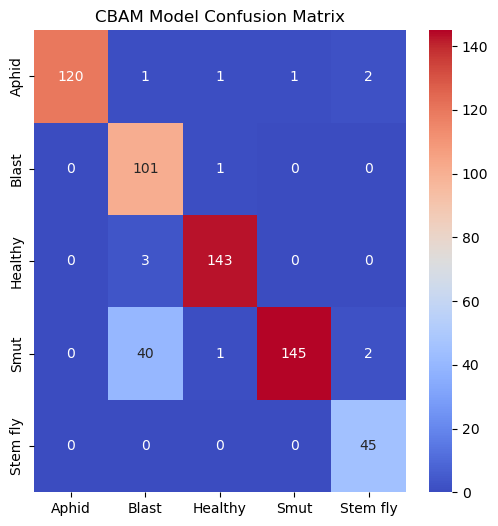

In [68]:
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_cbam_cm,xticklabels=selected_classes,yticklabels=selected_classes,annot=True,cmap="coolwarm",fmt="")
plt.title("CBAM Model Confusion Matrix")

Text(0.5, 1.0, 'BAM Model Confusion Matrix')

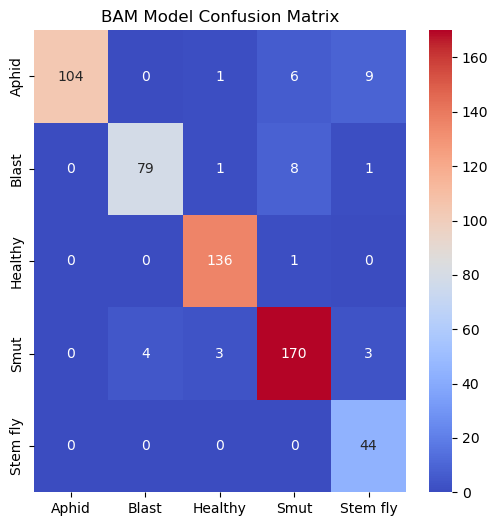

In [69]:
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_bam_cm,xticklabels=selected_classes,yticklabels=selected_classes,annot=True,cmap="coolwarm",fmt="")
plt.title("BAM Model Confusion Matrix")

Text(0.5, 1.0, 'SSD CBAMobile Detector Model Confusion Matrix')

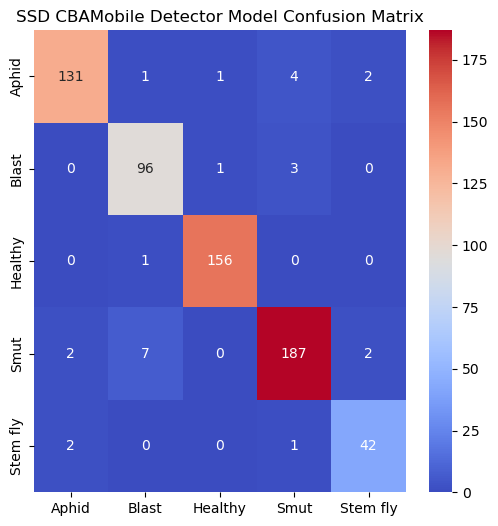

In [70]:
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_ssd_cm,xticklabels=selected_classes,yticklabels=selected_classes,annot=True,cmap="coolwarm",fmt="")
plt.title("SSD CBAMobile Detector Model Confusion Matrix")

Text(0.5, 1.0, 'CBAM AutoEncoder Classification Head Model Confusion Matrix')

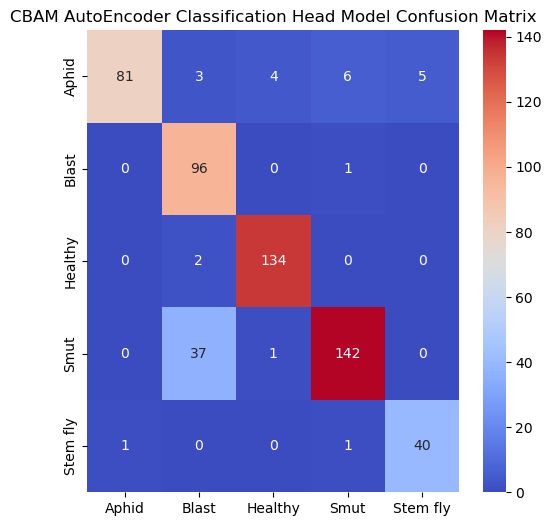

In [71]:
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_cbam_ae_cm,xticklabels=selected_classes,yticklabels=selected_classes,annot=True,cmap="coolwarm",fmt="")
plt.title("CBAM AutoEncoder Classification Head Model Confusion Matrix")

In [93]:
def calculate_metrics(conf_matrix, class_names=None):
    num_classes = conf_matrix.shape[0]  # Number of classes
    total_samples = np.sum(conf_matrix)  # Total number of samples

    # Initialize lists
    precision_list = []
    recall_list = []
    f1_score_list = []
    accuracy_list = []
    sensitivity_list = []

    # Compute Precision, Recall, F1-score, Accuracy, and Sensitivity for each class
    for i in range(num_classes):
        TP = conf_matrix[i, i]  # True Positives
        FP = np.sum(conf_matrix[:, i]) - TP  # False Positives (Column sum - TP)
        FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives (Row sum - TP)
        TN = total_samples - (TP + FP + FN)  # True Negatives

        # Compute metrics, handling zero division cases
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / total_samples 
        sensitivity = recall  # Sensitivity is the same as Recall
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        accuracy_list.append(accuracy)
        sensitivity_list.append(sensitivity)

    # Compute Macro-Averaged Metrics
    macro_precision = np.mean(precision_list)
    macro_recall = np.mean(recall_list)
    macro_f1_score = np.mean(f1_score_list)
    macro_sensitivity = np.mean(sensitivity_list)

    # Compute Micro-Averaged Metrics
    total_TP = np.sum([conf_matrix[i, i] for i in range(num_classes)])
    total_FP = np.sum(conf_matrix) - np.sum(np.diag(conf_matrix))  # Sum of all FP
    total_FN = total_FP  # In a confusion matrix, sum of FP = sum of FN

    micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    micro_f1_score = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Compute Overall Accuracy
    overall_accuracy = np.trace(conf_matrix) / total_samples  # Sum of diagonal / Total Samples

    # Create DataFrame for class-wise metrics
    df = pd.DataFrame({
        "Class": class_names if class_names else [f"Class {i}" for i in range(num_classes)],
        "Precision": precision_list,
        "Recall": recall_list,
        "F1-score": f1_score_list,
        "Accuracy": accuracy_list,
        "Sensitivity": sensitivity_list
    })

    # Create dictionary for overall metrics
    overall_metrics = {
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-score": macro_f1_score,
        "Micro Precision": micro_precision,
        "Micro Recall": micro_recall,
        "Micro F1-score": micro_f1_score,
        "Overall Accuracy": overall_accuracy,
        "Macro Sensitivity": macro_sensitivity
    }

    return df, overall_metrics

In [95]:
print("CBAM model Confusion Matrix for selected Classes")
print("=======================================================")
cbam_selected_df,overall_cbam = calculate_metrics(filtered_cbam_cm,selected_classes)
print(cbam_selected_df.to_string(index=False)) 
print("===================================")
print(pd.DataFrame(overall_cbam, index=["Overall"]))

CBAM model Confusion Matrix for selected Classes
   Class  Precision   Recall  F1-score  Accuracy  Sensitivity
   Aphid   1.000000 0.960000  0.979592  0.991749     0.960000
   Blast   0.696552 0.990196  0.817814  0.925743     0.990196
 Healthy   0.979452 0.979452  0.979452  0.990099     0.979452
    Smut   0.993151 0.771277  0.868263  0.927393     0.771277
Stem fly   0.918367 1.000000  0.957447  0.993399     1.000000
         Macro Precision  Macro Recall  Macro F1-score  Micro Precision  \
Overall         0.917504      0.940185        0.920514         0.914191   

         Micro Recall  Micro F1-score  Overall Accuracy  Macro Sensitivity  
Overall      0.914191        0.914191          0.914191           0.940185  


In [96]:
print("BAM model Confusion Matrix for selected Classes")
print("=======================================================")
bam_selected_df,overall_bam  = calculate_metrics(filtered_bam_cm,selected_classes)
print(bam_selected_df.to_string(index=False)) 
print("===================================")
print(pd.DataFrame(overall_bam, index=["Overall"]))

BAM model Confusion Matrix for selected Classes
   Class  Precision   Recall  F1-score  Accuracy  Sensitivity
   Aphid   1.000000 0.866667  0.928571  0.971930     0.866667
   Blast   0.951807 0.887640  0.918605  0.975439     0.887640
 Healthy   0.964539 0.992701  0.978417  0.989474     0.992701
    Smut   0.918919 0.944444  0.931507  0.956140     0.944444
Stem fly   0.771930 1.000000  0.871287  0.977193     1.000000
         Macro Precision  Macro Recall  Macro F1-score  Micro Precision  \
Overall         0.921439       0.93829        0.925677         0.935088   

         Micro Recall  Micro F1-score  Overall Accuracy  Macro Sensitivity  
Overall      0.935088        0.935088          0.935088            0.93829  


In [97]:
print("SSD CBAMobile Detector Confusion Matrix for selected Classes")
print("=======================================================")
ssd_selected_df,overall_ssd = calculate_metrics(filtered_ssd_cm,selected_classes)
print(ssd_selected_df.to_string(index=False)) 
print("===================================")
print(pd.DataFrame(overall_ssd, index=["Overall"]))

SSD CBAMobile Detector Confusion Matrix for selected Classes
   Class  Precision   Recall  F1-score  Accuracy  Sensitivity
   Aphid   0.970370 0.942446  0.956204  0.981221     0.942446
   Blast   0.914286 0.960000  0.936585  0.979656     0.960000
 Healthy   0.987342 0.993631  0.990476  0.995305     0.993631
    Smut   0.958974 0.944444  0.951654  0.970266     0.944444
Stem fly   0.913043 0.933333  0.923077  0.989045     0.933333
         Macro Precision  Macro Recall  Macro F1-score  Micro Precision  \
Overall         0.948803      0.954771        0.951599         0.957746   

         Micro Recall  Micro F1-score  Overall Accuracy  Macro Sensitivity  
Overall      0.957746        0.957746          0.957746           0.954771  


In [98]:
print("CBAM AutoEncoder Classification Head model Confusion Matrix for selected Classes")
print("=======================================================")
cbam_ae_selected_df,overall_cbam_ae = calculate_metrics(filtered_cbam_ae_cm,selected_classes)
print(cbam_ae_selected_df.to_string(index=False)) 
print("===================================")
print(pd.DataFrame(overall_cbam_ae, index=["Overall"]))

CBAM AutoEncoder Classification Head model Confusion Matrix for selected Classes
   Class  Precision   Recall  F1-score  Accuracy  Sensitivity
   Aphid   0.987805 0.818182  0.895028  0.965704     0.818182
   Blast   0.695652 0.989691  0.817021  0.922383     0.989691
 Healthy   0.964029 0.985294  0.974545  0.987365     0.985294
    Smut   0.946667 0.788889  0.860606  0.916968     0.788889
Stem fly   0.888889 0.952381  0.919540  0.987365     0.952381
         Macro Precision  Macro Recall  Macro F1-score  Micro Precision  \
Overall         0.896608      0.906887        0.893348         0.889892   

         Micro Recall  Micro F1-score  Overall Accuracy  Macro Sensitivity  
Overall      0.889892        0.889892          0.889892           0.906887  


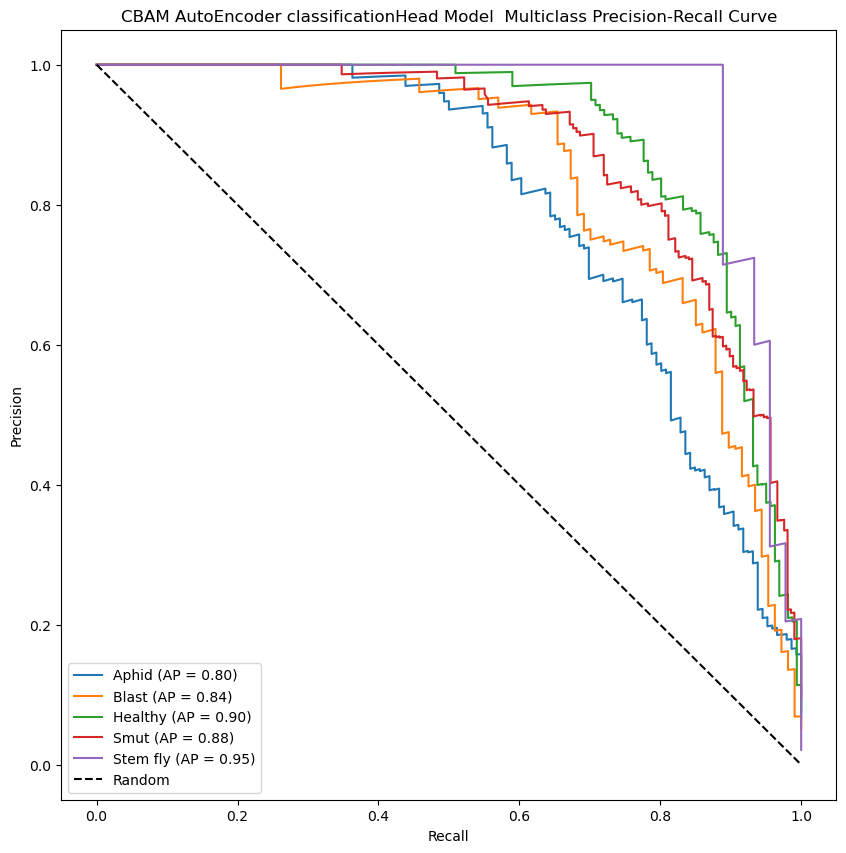

In [77]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_ae_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CBAM AutoEncoder classificationHead Model  Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

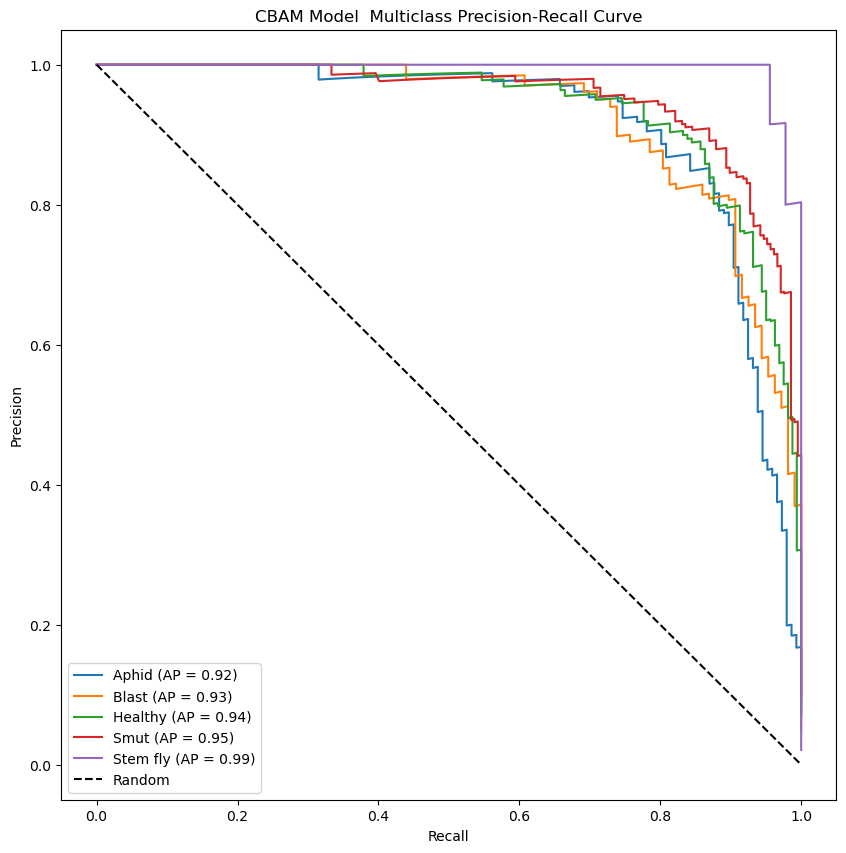

In [78]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CBAM Model  Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

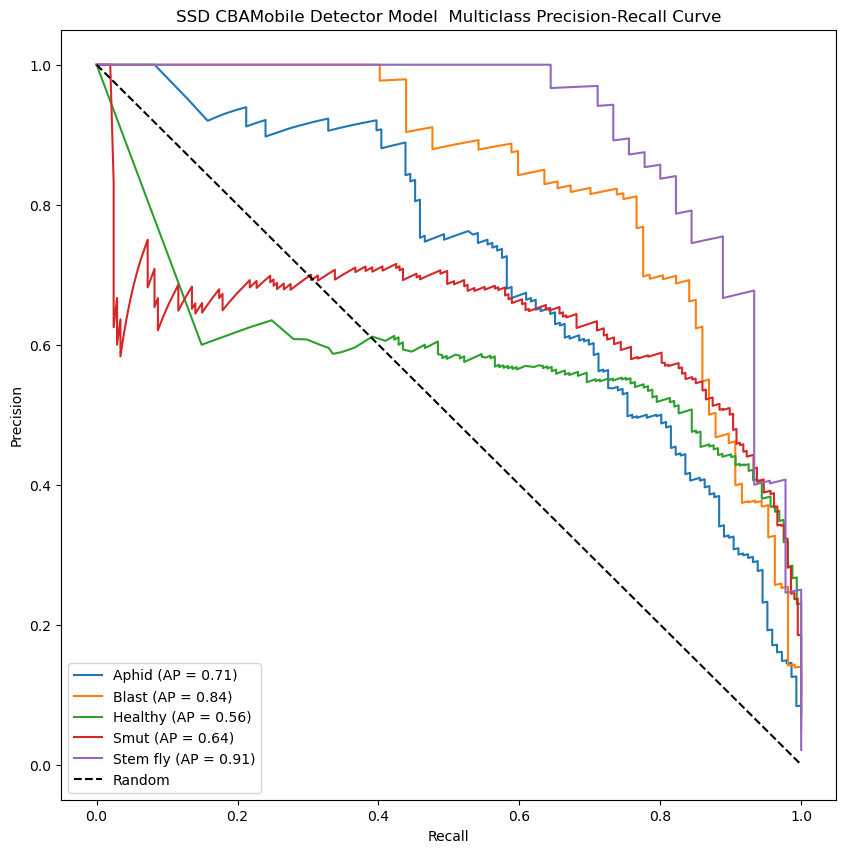

In [79]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = ssd_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SSD CBAMobile Detector Model  Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

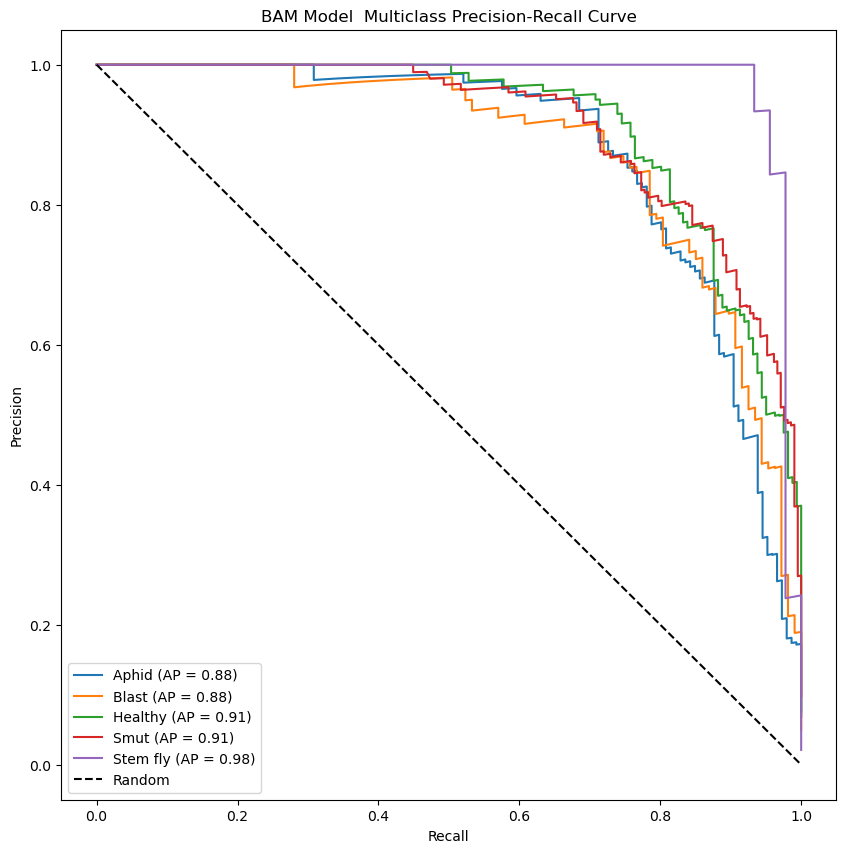

In [80]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = bam_predictions 
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP = {average_precision[i]:.2f})')

plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('BAM Model  Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

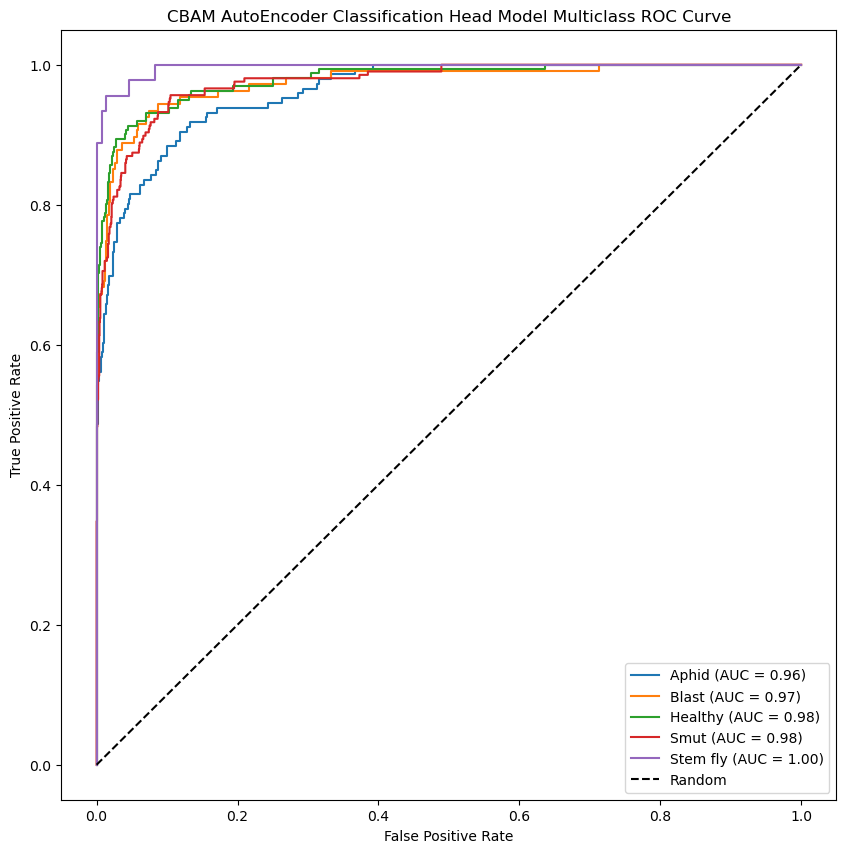

In [81]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_ae_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CBAM AutoEncoder Classification Head Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

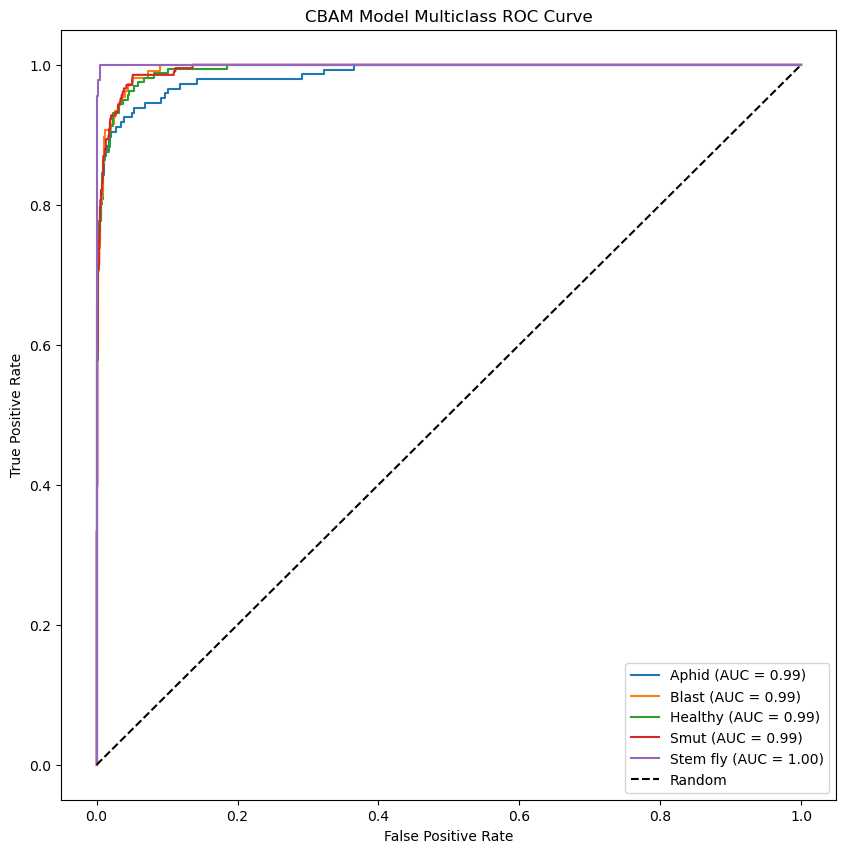

In [82]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = cbam_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CBAM Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

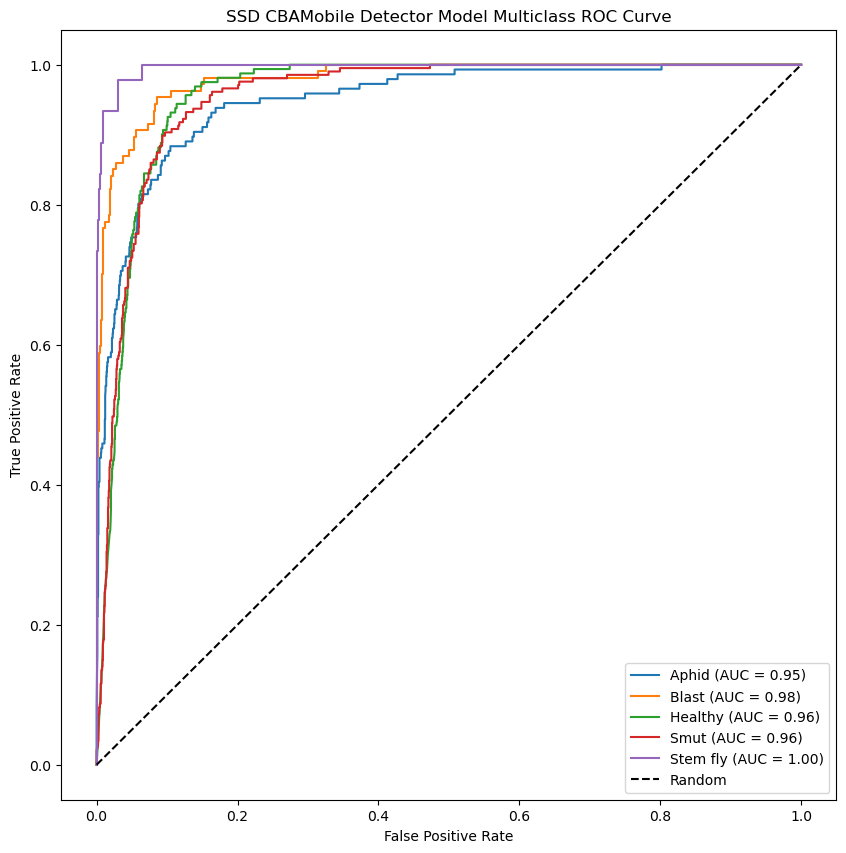

In [83]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = ssd_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SSD CBAMobile Detector Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

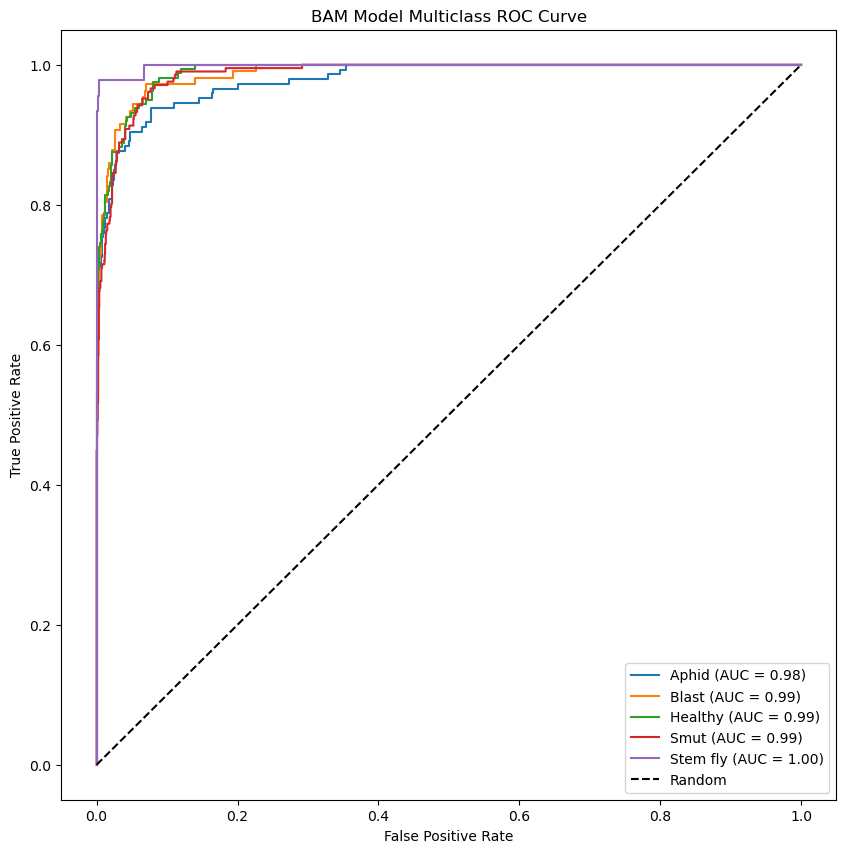

In [84]:
n_classes = len(np.unique(test_data.classes))
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))
y_pred = bam_predictions  
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    if i in selected_indices:
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BAM Model Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

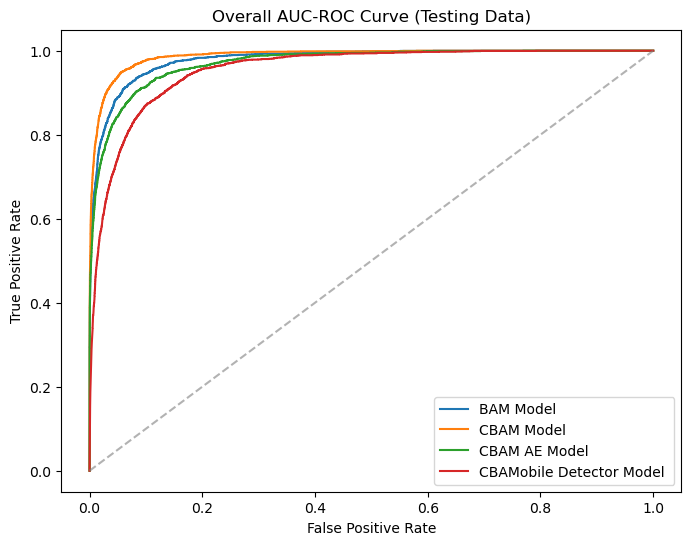

In [107]:
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))  
y_pred_bam = bam_predictions  
y_pred_cbam = cbam_predictions 
y_pred_ae = cbam_ae_predictions  
y_pred_ssd = ssd_predictions  

plt.figure(figsize=(8, 6))


fpr_bam, tpr_bam, _ = roc_curve(y_true.ravel(), y_pred_bam.ravel())  
roc_auc_bam = auc(fpr_bam, tpr_bam)
fpr_cbam, tpr_cbam, _ = roc_curve(y_true.ravel(), y_pred_cbam.ravel())  
roc_auc_cbam = auc(fpr_cbam, tpr_cbam)
fpr_ae, tpr_ae, _ = roc_curve(y_true.ravel(), y_pred_ae.ravel())  
roc_auc_ae = auc(fpr_ae, tpr_ae)
fpr_ssd, tpr_ssd, _ = roc_curve(y_true.ravel(), y_pred_ssd.ravel())  
roc_auc_ssd = auc(fpr_ssd, tpr_ssd)

# Plot ROC curve
plt.plot(fpr_bam, tpr_bam, label=f'BAM Model')
plt.plot(fpr_cbam, tpr_cbam, label=f'CBAM Model ')
plt.plot(fpr_ae, tpr_ae, label=f'CBAM AE Model ')
plt.plot(fpr_ssd, tpr_ssd, label=f'CBAMobile Detector Model ')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall AUC-ROC Curve (Testing Data)")
plt.legend()
plt.show()